In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
import pandas as pd
import numpy as np
import pickle as pkl
import time

In [2]:
FORECAST_PERIOD=48

In [3]:
data_df = pd.read_csv("../Data/pre_processed_final_data.csv")
data_df['date_time'] = pd.to_datetime(data_df['date_time'], infer_datetime_format=True, dayfirst=False)
data_df.set_index('date_time', inplace=True)

In [4]:
data_df.columns

Index(['System Sell Price(GBP/MWh)', 'System Buy Price(GBP/MWh)',
       'Net Imbalance Volume(MWh)', 'ND', 'TSD', 'ENGLAND_WALES_DEMAND',
       'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
       'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR',
       'PUMP_STORAGE_PUMPING', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW',
       'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW',
       'ELECLINK_FLOW', 'INTFR(MW)', 'INTIRL(MW)', 'INTNED(MW)', 'INTEW(MW)',
       'INTNEM(MW)', 'Rolling_Demand',
       'Fossil Gas_remit_Available_Capacity_rate(MWh)',
       'Biomass_remit_Available_Capacity_rate(MWh)',
       'Wind Offshore_remit_Available_Capacity_rate(MWh)',
       'Fossil Oil_remit_Available_Capacity_rate(MWh)',
       'Nuclear_remit_Available_Capacity_rate(MWh)',
       'Fossil Hard coal_remit_Available_Capacity_rate(MWh)',
       'Other_remit_Available_Capacity_rate(MWh)',
       'Wind Onshore_remit_Available_Capacity_rate(MWh)',
       'temperature_2

In [5]:
idv_cols = ['Net Imbalance Volume(MWh)', 'ND', 'TSD', 'ENGLAND_WALES_DEMAND',
            'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
            'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR',
            'PUMP_STORAGE_PUMPING', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW',
            'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW',
            'ELECLINK_FLOW', 'INTFR(MW)', 'INTIRL(MW)', 'INTNED(MW)', 'INTEW(MW)',
            'INTNEM(MW)', 'Rolling_Demand',
            'Fossil Gas_remit_Available_Capacity_rate(MWh)',
            'Biomass_remit_Available_Capacity_rate(MWh)',
            'Wind Offshore_remit_Available_Capacity_rate(MWh)',
            'Fossil Oil_remit_Available_Capacity_rate(MWh)',
            'Nuclear_remit_Available_Capacity_rate(MWh)',
            'Fossil Hard coal_remit_Available_Capacity_rate(MWh)',
            'Other_remit_Available_Capacity_rate(MWh)',
            'Wind Onshore_remit_Available_Capacity_rate(MWh)',
            'temperature_2m(°C)_England', 'relativehumidity_2m(%)_England',
            'dewpoint_2m(°C)_England', 'precipitation(mm)_England',
            'windspeed_100m(km/h)_England', 'temperature_2m(°C)_Wales',
            'relativehumidity_2m(%)_Wales', 'dewpoint_2m(°C)_Wales',
            'precipitation(mm)_Wales', 'windspeed_100m(km/h)_Wales']

In [6]:
dv_col ='System Sell Price(GBP/MWh)'

In [7]:
print("before shift", data_df.shape)
data_df[dv_col + "_forecast_period" + str(FORECAST_PERIOD)] = data_df[dv_col].shift(-FORECAST_PERIOD)
data_df = data_df.iloc[:-FORECAST_PERIOD]
dv_col = dv_col + "_forecast_period" + str(FORECAST_PERIOD)
print("after shift", data_df.shape)

before shift (79968, 44)
after shift (79920, 45)


In [8]:
# Creating future data set for prediction table
eval_df = data_df.iloc[-FORECAST_PERIOD:]
eval_df = eval_df[idv_cols]

In [9]:
X_df = data_df[idv_cols]
y_df = data_df[[dv_col]]

In [10]:
X_train_df = X_df[:'2022-12-31']
X_test_df  = X_df['2023-01-01':]

In [11]:
y_train_df = y_df[:'2022-12-31']
y_test_df  = y_df['2023-01-01':]

In [12]:
dv_scalar_model = StandardScaler()
dv_scalar_model.fit(y_train_df)

StandardScaler()

In [13]:
with open("../Models/dv_scalar_model.pkl", mode='wb') as file:
    pkl.dump(dv_scalar_model, file)
    file.close()

In [14]:
y_train_transform_df = y_train_df.copy(deep=True)
y_train_transform_df[dv_col] = dv_scalar_model.transform(y_train_df)

In [15]:
y_test_transform_df = y_test_df.copy(deep=True)
print(y_test_transform_df)
y_test_transform_df[dv_col] = dv_scalar_model.transform(y_test_df)
print(y_test_transform_df)

                     System Sell Price(GBP/MWh)_forecast_period48
date_time                                                        
2023-01-01 00:00:00                                     172.68000
2023-01-01 00:30:00                                     182.34000
2023-01-01 01:00:00                                      42.00000
2023-01-01 01:30:00                                      42.00000
2023-01-01 02:00:00                                      42.00000
...                                                           ...
2023-07-23 21:30:00                                     107.91019
2023-07-23 22:00:00                                     123.50000
2023-07-23 22:30:00                                     123.00000
2023-07-23 23:00:00                                     110.00000
2023-07-23 23:30:00                                      91.16000

[9792 rows x 1 columns]
                     System Sell Price(GBP/MWh)_forecast_period48
date_time                                          

In [16]:
scaler_model = MinMaxScaler()
scaler_model.fit(X_train_df)

MinMaxScaler()

In [17]:
with open("../Models/minmax_scalar_model.pkl", mode='wb') as file:
    pkl.dump(scaler_model, file)
    file.close()

In [18]:
X_train_transform_df = pd.DataFrame(scaler_model.transform(X_train_df), columns=X_train_df.columns)
X_train_transform_df.set_index(X_train_df.index, inplace=True)

In [19]:
X_test_transform_df = pd.DataFrame(scaler_model.transform(X_test_df), columns=X_test_df.columns)
X_test_transform_df.set_index(X_test_df.index, inplace=True)

In [20]:
X_test_transform_df

,Net Imbalance Volume(MWh),ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,...,temperature_2m(°C)_England,relativehumidity_2m(%)_England,dewpoint_2m(°C)_England,precipitation(mm)_England,windspeed_100m(km/h)_England,temperature_2m(°C)_Wales,relativehumidity_2m(%)_Wales,dewpoint_2m(°C)_Wales,precipitation(mm)_Wales,windspeed_100m(km/h)_Wales
date_time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.509007,0.227680,0.250256,0.446364,0.509940,0.955793,0.0,0.034611,0.0,0.598762,...,0.355609,0.857143,0.561562,0.0,0.463007,0.419903,0.927536,0.538700,0.209677,0.645638
2023-01-01 00:30:00,0.615033,0.248828,0.269187,0.463635,0.505694,0.955793,0.0,0.034611,0.0,0.544611,...,0.352029,0.857143,0.555556,0.0,0.492840,0.412621,0.927536,0.529412,0.120968,0.702013
2023-01-01 01:00:00,0.536113,0.236727,0.268565,0.454165,0.501834,0.955793,0.0,0.034611,0.0,0.625064,...,0.348449,0.857143,0.549550,0.0,0.522673,0.405340,0.927536,0.520124,0.032258,0.758389
2023-01-01 01:30:00,0.450420,0.214125,0.246962,0.436823,0.497973,0.955793,0.0,0.034611,0.0,0.637958,...,0.344869,0.844156,0.542042,0.0,0.578162,0.405340,0.913043,0.515480,0.040323,0.724161
2023-01-01 02:00:00,0.446003,0.190247,0.233316,0.418423,0.490060,0.955793,0.0,0.034611,0.0,0.635895,...,0.341289,0.831169,0.534535,0.0,0.633652,0.405340,0.898551,0.510836,0.048387,0.689933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-23 21:30:00,0.511172,0.222726,0.252805,0.455481,0.258830,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.740260,0.462462,0.0,0.264916,0.388350,0.826087,0.467492,0.000000,0.213423
2023-07-23 22:00:00,0.475146,0.222726,0.252805,0.455481,0.258830,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.740260,0.462462,0.0,0.264916,0.388350,0.826087,0.467492,0.000000,0.213423
2023-07-23 22:30:00,0.423487,0.222726,0.252805,0.455481,0.258830,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.740260,0.462462,0.0,0.264916,0.388350,0.826087,0.467492,0.000000,0.213423


In [21]:
X_eval_transform_df = pd.DataFrame(scaler_model.transform(eval_df), columns=eval_df.columns)
X_eval_transform_df.set_index(eval_df.index, inplace=True)

In [22]:
X_eval_transform_df

,Net Imbalance Volume(MWh),ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,...,temperature_2m(°C)_England,relativehumidity_2m(%)_England,dewpoint_2m(°C)_England,precipitation(mm)_England,windspeed_100m(km/h)_England,temperature_2m(°C)_Wales,relativehumidity_2m(%)_Wales,dewpoint_2m(°C)_Wales,precipitation(mm)_Wales,windspeed_100m(km/h)_Wales
date_time,,,,,,,,,,,,,,,,,,,,,
2023-07-23 00:00:00,0.395581,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 00:30:00,0.378323,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 01:00:00,0.374508,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 01:30:00,0.349216,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 02:00:00,0.359611,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 02:30:00,0.295304,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 03:00:00,0.324106,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 03:30:00,0.307727,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423
2023-07-23 04:00:00,0.308504,0.222726,0.252805,0.455481,0.25883,0.945122,0.0,1.524104,0.0,0.002579,...,0.312649,0.74026,0.462462,0.0,0.264916,0.38835,0.826087,0.467492,0.0,0.213423


In [23]:
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    train_X=params['X_train']
    train_y=params['y_train']
    test_X=params['X_test']
    test_y=params['y_test']
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(train_X,train_y)
    pred=model.predict(test_X)
    score= 1 - r2_score(test_y, pred)
    return score

In [24]:
def optimize(trial, train_X, train_y, test_X, test_y):
    params={'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6),
           'X_train':train_X,
           'y_train':train_y,
           'X_test':test_X,
           'y_test':test_y}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=10)
    return best

In [25]:
trial=Trials()
best=optimize(trial,
              X_train_transform_df, y_train_transform_df[dv_col],
              X_test_transform_df, y_test_transform_df[dv_col])

100%|█████████| 10/10 [44:11<00:00, 265.18s/trial, best loss: 2.647913750849317]


In [26]:
print(best)

{'max_depth': 17.121851985007805, 'min_samples_leaf': 4.340908080101011, 'min_samples_split': 5.47928766130819, 'n_estimators': 467.1100070344691}


In [27]:
model=RandomForestRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            min_samples_leaf=int(best['min_samples_leaf']),
                            min_samples_split=int(best['min_samples_split']))

In [28]:
model.fit(X_train_transform_df, y_train_transform_df[dv_col])

RandomForestRegressor(max_depth=17, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=467)

In [29]:
with open("../Models/regression_randomforest_model.pkl", mode='wb') as file:
    pkl.dump(model, file)
    file.close()

In [30]:
train_pred = model.predict(X_train_transform_df)

In [31]:
test_pred = model.predict(X_test_transform_df)

In [32]:
mse = mean_squared_error(test_pred, y_test_transform_df[dv_col])
r2 = r2_score(test_pred, y_test_transform_df[dv_col])
print("MSE", mse)
print("R2", r2)

MSE 0.8501784869545566
R2 -1.215813121489096


In [33]:
test_pred_df = y_test_df.copy(deep=True)
test_pred_df[dv_col] = test_pred
test_pred_df[dv_col] = dv_scalar_model.inverse_transform(test_pred_df)

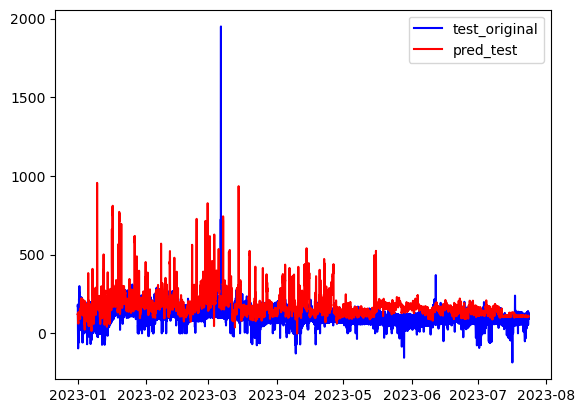

In [34]:
plt.plot(y_test_df.index, y_test_df[dv_col], c='b',label='test_original')
plt.plot(y_test_df.index, test_pred_df[dv_col], c='r',label='pred_test')
plt.legend(loc='best')
# plt.show()
plt.savefig("../Output/Regression_randomforest_pred.png")

In [35]:
features = model.feature_importances_
features_df = pd.DataFrame(features, index=idv_cols)
features_df.rename(columns={0: "importance score"}, inplace=True)
features_df.sort_values(by="importance score", ascending=False)

,importance score
EMBEDDED_SOLAR_CAPACITY,0.306182
NSL_FLOW,0.120852
ND,0.049180
temperature_2m(°C)_Wales,0.046063
temperature_2m(°C)_England,0.042526
ENGLAND_WALES_DEMAND,0.038741
IFA_FLOW,0.035320
MOYLE_FLOW,0.033091
EMBEDDED_WIND_GENERATION,0.032941
windspeed_100m(km/h)_England,0.028273


In [37]:
eval_pred = model.predict(X_eval_transform_df)
eval_df[dv_col +"transformed_prediction"] = eval_pred

In [43]:
eval_df['predicted'] = dv_scalar_model.inverse_transform(eval_df[dv_col +"transformed_prediction"].to_frame())

In [47]:
eval_df[['predicted']]

,predicted
date_time,
2023-07-23 00:00:00,104.037572
2023-07-23 00:30:00,102.941210
2023-07-23 01:00:00,103.392172
2023-07-23 01:30:00,103.781086
2023-07-23 02:00:00,103.429490
2023-07-23 02:30:00,103.832810
2023-07-23 03:00:00,103.781086
2023-07-23 03:30:00,103.832810
2023-07-23 04:00:00,103.832810


In [49]:
eval_df.to_csv("../Data/predicted_data.csv")